In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Modelling
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

### Import CSV data to pandas DataFrame

In [6]:
df = pd.read_csv('data/stud.csv')

In [8]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Adding total_score and Average columns

In [9]:
df['total_score'] = df['math_score'] + df['reading_score'] + df['writing_score']
df['Average'] = df['total_score']/3
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,Average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667
1,female,group C,some college,standard,completed,69,90,88,247,82.333333
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333
4,male,group C,some college,standard,none,76,78,75,229,76.333333


In [30]:
X = df.drop(columns='Average',axis=1)

In [31]:
X

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229
...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,282
996,male,group C,high school,free/reduced,none,62,55,55,172
997,female,group C,high school,free/reduced,completed,59,71,65,195
998,female,group D,some college,standard,completed,68,78,77,223


In [32]:
# create numeric and clasification columns
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns
num_features, cat_features

(Index(['math_score', 'reading_score', 'writing_score', 'total_score'], dtype='object'),
 Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
        'test_preparation_course'],
       dtype='object'))

In [27]:
y = df['Average']
y

0      72.666667
1      82.333333
2      92.666667
3      49.333333
4      76.333333
         ...    
995    94.000000
996    57.333333
997    65.000000
998    74.333333
999    83.000000
Name: Average, Length: 1000, dtype: float64

In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder",oh_transformer,cat_features),
        ("StandardScaler",numeric_transformer,num_features),
    ]
)

In [35]:
X = preprocessor.fit_transform(X)

### Split data into train and test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 21), (200, 21))

### Create Evaluate function to give all metrics after model training

In [46]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true,predicted)
    
    return mae,rmse,r2_square

In [47]:
models = {
    "Linear Regression" : LinearRegression(),
#     "Lasso" : Lasso(),
#     "Ridge" : Ridge(),
    "K-Neighbors Regressor" : KNeighborsRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train) # Train model
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 1.9820
- Mean Absolute Error: 1.5577
- R2 Score: 0.9803
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.6661
- Mean Absolute Error: 1.9230
- R2 Score: 0.9668


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.7145
- Mean Absolute Error: 0.1017
- R2 Score: 0.9976


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1063
- Mean Absolute Error: 0.0245
- R2 Score: 0.99

### Result

In [48]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,1.000000
2,Decision Tree,0.997618
4,XGBRegressor,0.997431
3,Random Forest Regressor,0.996381
5,CatBoosting Regressor,0.994961
6,AdaBoost Regressor,0.991741
1,K-Neighbors Regressor,0.966842


## Linear Regression


In [49]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 100.00


### Plot y_pred and y_test

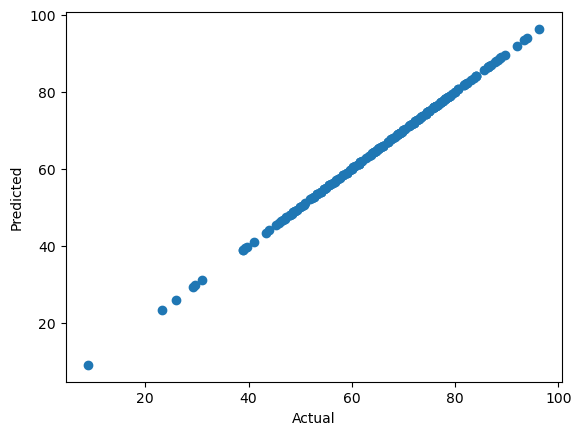

In [50]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

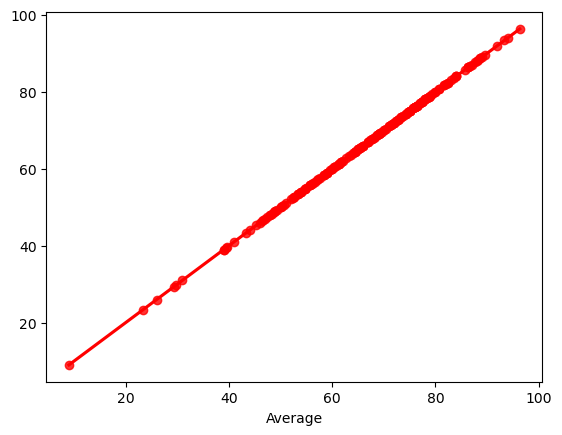

In [51]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

### Difference between Actual and Predicted Values

In [52]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,87.000000,87.000000,0.000000e+00
737,64.000000,64.000000,7.105427e-15
740,75.000000,75.000000,1.421085e-14
660,74.666667,74.666667,1.421085e-14
411,81.666667,81.666667,1.421085e-14
...,...,...,...
408,55.000000,55.000000,7.105427e-15
332,57.000000,57.000000,1.421085e-14
208,77.000000,77.000000,0.000000e+00
613,72.000000,72.000000,1.421085e-14
